In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *
%matplotlib inline

In [2]:
grocery_items = set()
with open('grocery_dataset.txt') as f:
    reader = csv.reader(f, delimiter = ',')
    for i, line in enumerate(reader):
        grocery_items.update(line)
        
output_list = list()
with open('grocery_dataset.txt') as f:
    reader = csv.reader(f, delimiter = ',')
    for i, line in enumerate(reader):
        row_val = {item: 0 for item in grocery_items}
        row_val.update({item: 1 for item in line})
        output_list.append(row_val)
        
grocery_df = pd.DataFrame(output_list)

In [11]:
# we have 9,835 total transactions and a total of 169 items
grocery_df.shape

(9835, 169)

In [15]:
# what are top 10 items that occur in the dataset ? 
# and how much of the total sales they account for ?
total_item_count = sum(grocery_df.sum())
print(total_item_count)
item_summary_df = grocery_df.sum().sort_values(ascending = False).reset_index().head(n = 20)
item_summary_df.rename(columns = {item_summary_df.columns[0]: 'item_name',
                                  item_summary_df.columns[1]: 'item_count'},
                       inplace = True)
item_summary_df.head()

43367


,item_name,item_count
0,whole milk,2513
1,other vegetables,1903
2,rolls/buns,1809
3,soda,1715
4,yogurt,1372


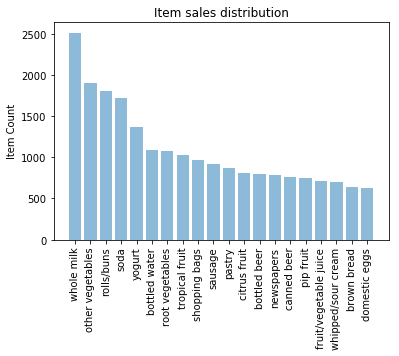

In [19]:
objects = (list(item_summary_df['item_name'].head(n = 20)))
y_pos = np.arange(len(objects))
performance = list(item_summary_df['item_count'].head(n = 20))

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects, rotation = 'vertical')
plt.ylabel('Item Count')
plt.title('Item sales distribution')

In [20]:
# how much percentage of total sales is explained by these 20 items alone
item_summary_df['item_perc'] = item_summary_df['item_count'] / total_item_count
item_summary_df['total_perc'] = item_summary_df.item_perc.cumsum()
item_summary_df.head(10)


,item_name,item_count,item_perc,total_perc
0,whole milk,2513,0.057947,0.057947
1,other vegetables,1903,0.043881,0.101829
2,rolls/buns,1809,0.041714,0.143542
3,soda,1715,0.039546,0.183089
4,yogurt,1372,0.031637,0.214725
5,bottled water,1087,0.025065,0.239791
6,root vegetables,1072,0.024719,0.264510
7,tropical fruit,1032,0.023797,0.288307
8,shopping bags,969,0.022344,0.310651
9,sausage,924,0.021307,0.331957


In [21]:
# top five items are responsible for 21.4% of the entire sales
item_summary_df[item_summary_df.total_perc <= 0.5].shape


(19, 4)

In [22]:
# only the top 20 items are responsible for over 50% of the sales!
item_summary_df[item_summary_df.total_perc <= 0.5]

,item_name,item_count,item_perc,total_perc
0,whole milk,2513,0.057947,0.057947
1,other vegetables,1903,0.043881,0.101829
2,rolls/buns,1809,0.041714,0.143542
3,soda,1715,0.039546,0.183089
4,yogurt,1372,0.031637,0.214725
5,bottled water,1087,0.025065,0.239791
6,root vegetables,1072,0.024719,0.264510
7,tropical fruit,1032,0.023797,0.288307
8,shopping bags,969,0.022344,0.310651
9,sausage,924,0.021307,0.331957


# Construct Orange Table

In [25]:
# Define the domain of each variable
# domain means the possible set of values that each variables can use. 

import_assoc_rules = grocery_df
domain_grocery = Domain([DiscreteVariable.make(name = item,
                                               values = ['0', '1'])for item in import_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain = domain_grocery,
                                          X = import_assoc_rules.as_matrix(),
                                          Y = None)


## Prune Dataset for frequently purchased items

In [28]:
def prune_dataset(input_df,
                  length_trans = 2,
                  total_sales_perc = 0.5,
                  start_item = None,
                  end_item = None):
    
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns = {item_count.columns[0]: 'item_name', 
                                 item_count.columns[1]: 'item_count'},
                      inplace = True)
    
    if not start_item and not end_item:
        item_count['item_perc'] = item_count['item_count'] / total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]
    
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[start_item:end_item]


In [30]:
output_df, item_counts = prune_dataset(input_df = grocery_df, 
                                       length_trans = 2,
                                       total_sales_perc = 0.4)
print(output_df.shape)
print(list(output_df.columns))

#we have only 13 items responsible for 40% of sales 
# and 4585 transactions that have those items along with other items 


(4585, 13)
['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags', 'sausage', 'pastry', 'citrus fruit', 'bottled beer']


In [31]:
input_assoc_rules = output_df
domain_grocery = Domain([DiscreteVariable.make(name = item,
                                               values = ['0', '1']) for item in input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain = domain_grocery,
                                          X = input_assoc_rules.as_matrix(),
                                          Y = None)
data_gro_en, mapping = OneHot.encode(data_gro_1, 
                                     include_class = False)

In [33]:
min_support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0] * min_support))
num_trans = input_assoc_rules.shape[0] * min_support
itemsets = dict(frequent_itemsets(data_gro_en, min_support = min_support))


num of required transactions =  45


In [34]:
len(itemsets)

166886

In [36]:
# Specify a confidence value and generate rules
confidence = 0.3
rules_df = pd.DataFrame()

if len(itemsets) < 1000000:
    rules = [(P, Q, supp, conf) for P, Q, supp, conf in association_rules(itemsets, confidence) if len(Q) == 1]
    names = {item: '{} = {}'.format(var.name, val) for item, var, val in OneHot.decode(mapping, data_gro_1, mapping)}
    
    eligible_ante = [v for k, v in names.items() if v.endswith('1')]
    N = input_assoc_rules.shape[0] * 0.5
    rule_stats = list(rules_stats(rules, itemsets, N))
    rule_list_df = []
    
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            
            if ante_rule and len(rule_lhs) > 1:
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'converge' : ex_rule_frm_rule_stat[4],
                             'strength': ex_rule_frm_rule_stat[5],
                             'lift': ex_rule_frm_rule_stat[6],
                             'leverage': ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent': named_cons[:-2]}
                rule_list_df.append(rule_dict)
            
    rules_df = pd.DataFrame(rule_list_df)
    print('Raw rules data frame of {} rules generated'. format(rules_df.shape[0]))
    if not rules_df.empty:
        prune_rules_df = rules_df.groupby(['antecedent', 'consequent']).max().reset_index()
    else:
        print('Unable to generate any rule')
    

Raw rules data frame of 16628 rules generated


## Sorting rules in our Grocery Dataset

In [37]:
prune_rules_df[['antecedent', 
                 'consequent', 
                 'support', 
                 'confidence', 
                 'lift']].groupby('consequent').max().reset_index().sort_values(['lift',
                                                                                 'support',
                                                                                 'confidence'],
                                                                                ascending = False)
                                




,consequent,antecedent,support,confidence,lift
4,root vegetables =,"yogurt =, whole milk =, tropical fruit =",228,0.463636,1.115306
5,sausage =,"shopping bags =, rolls/buns =",59,0.393162,1.100519
8,tropical fruit =,"yogurt =, root vegetables =, whole milk =",92,0.429907,1.078294
1,citrus fruit =,"whole milk =, other vegetables =, tropical fru...",66,0.333333,1.062819
10,yogurt =,"whole milk =, tropical fruit =",199,0.484211,0.945530
2,other vegetables =,"yogurt =, whole milk =, tropical fruit =",228,0.643836,0.913362
6,shopping bags =,"soda =, sausage =",50,0.304878,0.891496
0,bottled water =,"yogurt =, soda =",59,0.333333,0.853818
9,whole milk =,"yogurt =, tropical fruit =",228,0.754098,0.851611
3,rolls/buns =,"yogurt =, whole milk =, tropical fruit =",97,0.522222,0.839547


In [ ]:
'''
The first pattern that the rule states in the equation is easy to understand
people who bought yogurt, whole milk, and tropical fruit also tend to buy root vegetables. 
'''